In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import tensorflow as tf
tf.python.control_flow_ops = tf

import lstm, time #helper libraries
import numpy as np
from sklearn.metrics import mean_squared_error
import math

from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)

Using TensorFlow backend.


In [27]:
def create_dataset(data, seq_len=3, tt_split=0.90, normalise_window=True):
    sequence_length = seq_len + 1
    result = []
    data_np = np.array(data)
    data_fl = data_np.astype(np.float)
    bounds = [np.amin(data_fl), np.amax(data_fl)]

    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_all(result)

    result = np.array(result)

    row = round(tt_split * result.shape[0])
    train = result[:int(row), :]
    #np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return x_train, y_train, x_test, y_test, bounds

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        mm = [min(window),max(window)] #minmax
        #print mm
        tr = [0.0, 1.0] #target range
        normalised_window = []
        for p in window:
            p_scaled = (p-mm[0])*(tr[1]-tr[0])/(mm[1]-mm[0])+tr[0]
            normalised_window.append(p_scaled)
        #normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def normalise_all(window_data):
    normalised_data = []
    temp = np.array(window_data)
    mm = [np.amin(temp),np.amax(temp)] #minmax
    tr = [0.0, 1.0] #target range
    for window in window_data:
        normalised_window = []
        for p in window:
            p_scaled = (p-mm[0])*(tr[1]-tr[0])/(mm[1]-mm[0])+tr[0]
            normalised_window.append(p_scaled)
        #normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [28]:
#Step 1 Load Data #load_data(filename, seq_len, normalise_window)
look_back = 50
tt_split = .90

f = open('sp500.csv', 'r').read()
data = f.split('\n')
data.pop(-1)
adj_close = np.array(data, dtype=float)

#print(data)

#X_train, y_train, X_test, y_test = lstm.load_data('sp500.csv', look_back, True)
X_train, y_train, X_test, y_test, close_bounds = create_dataset(adj_close, look_back, tt_split, True)

#print(X_train)
#print(X_test)

data_np = np.array(data)
data_fl = data_np.astype(np.float)
close_bounds = [np.amin(data_fl), np.amax(data_fl)]
print(close_bounds)

[676.53002900000001, 2175.030029]


In [29]:
#Step 2 Build Model
batch_size = 1
epochs=1
model = Sequential()

model.add(LSTM(50,batch_input_shape=(batch_size, look_back, 1),return_sequences=True))#, dropout_W=0.2))
model.add(Dropout(0.2))

model.add(LSTM(100,return_sequences=False)) #, dropout_W=0.2))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print 'compilation time : ', time.time() - start

compilation time :  3.52974891663


In [30]:
#Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    nb_epoch=epochs,
    validation_split=0.05)

Train on 3522 samples, validate on 186 samples
Epoch 1/1
3522/3522 [==============================] - 240s - loss: 0.0024 - val_loss: 6.9553e-04

In [31]:
# Scale function
def scale_range(X, input_range=[0.0,1.0], target_range=[0.0,1.0]):
    """
    Scales a numpy array to a new target range
    X = array of numbers
    target_range = new target min and max, default (0.0, 1.0)
    """
    orig_range = [X.min(axis=0),X.max(axis=0)]
    orig_range = [orig_range[0][0], orig_range[1][0]]
    X_std = (X - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    X_scaled = X_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]
    return X_scaled, orig_range

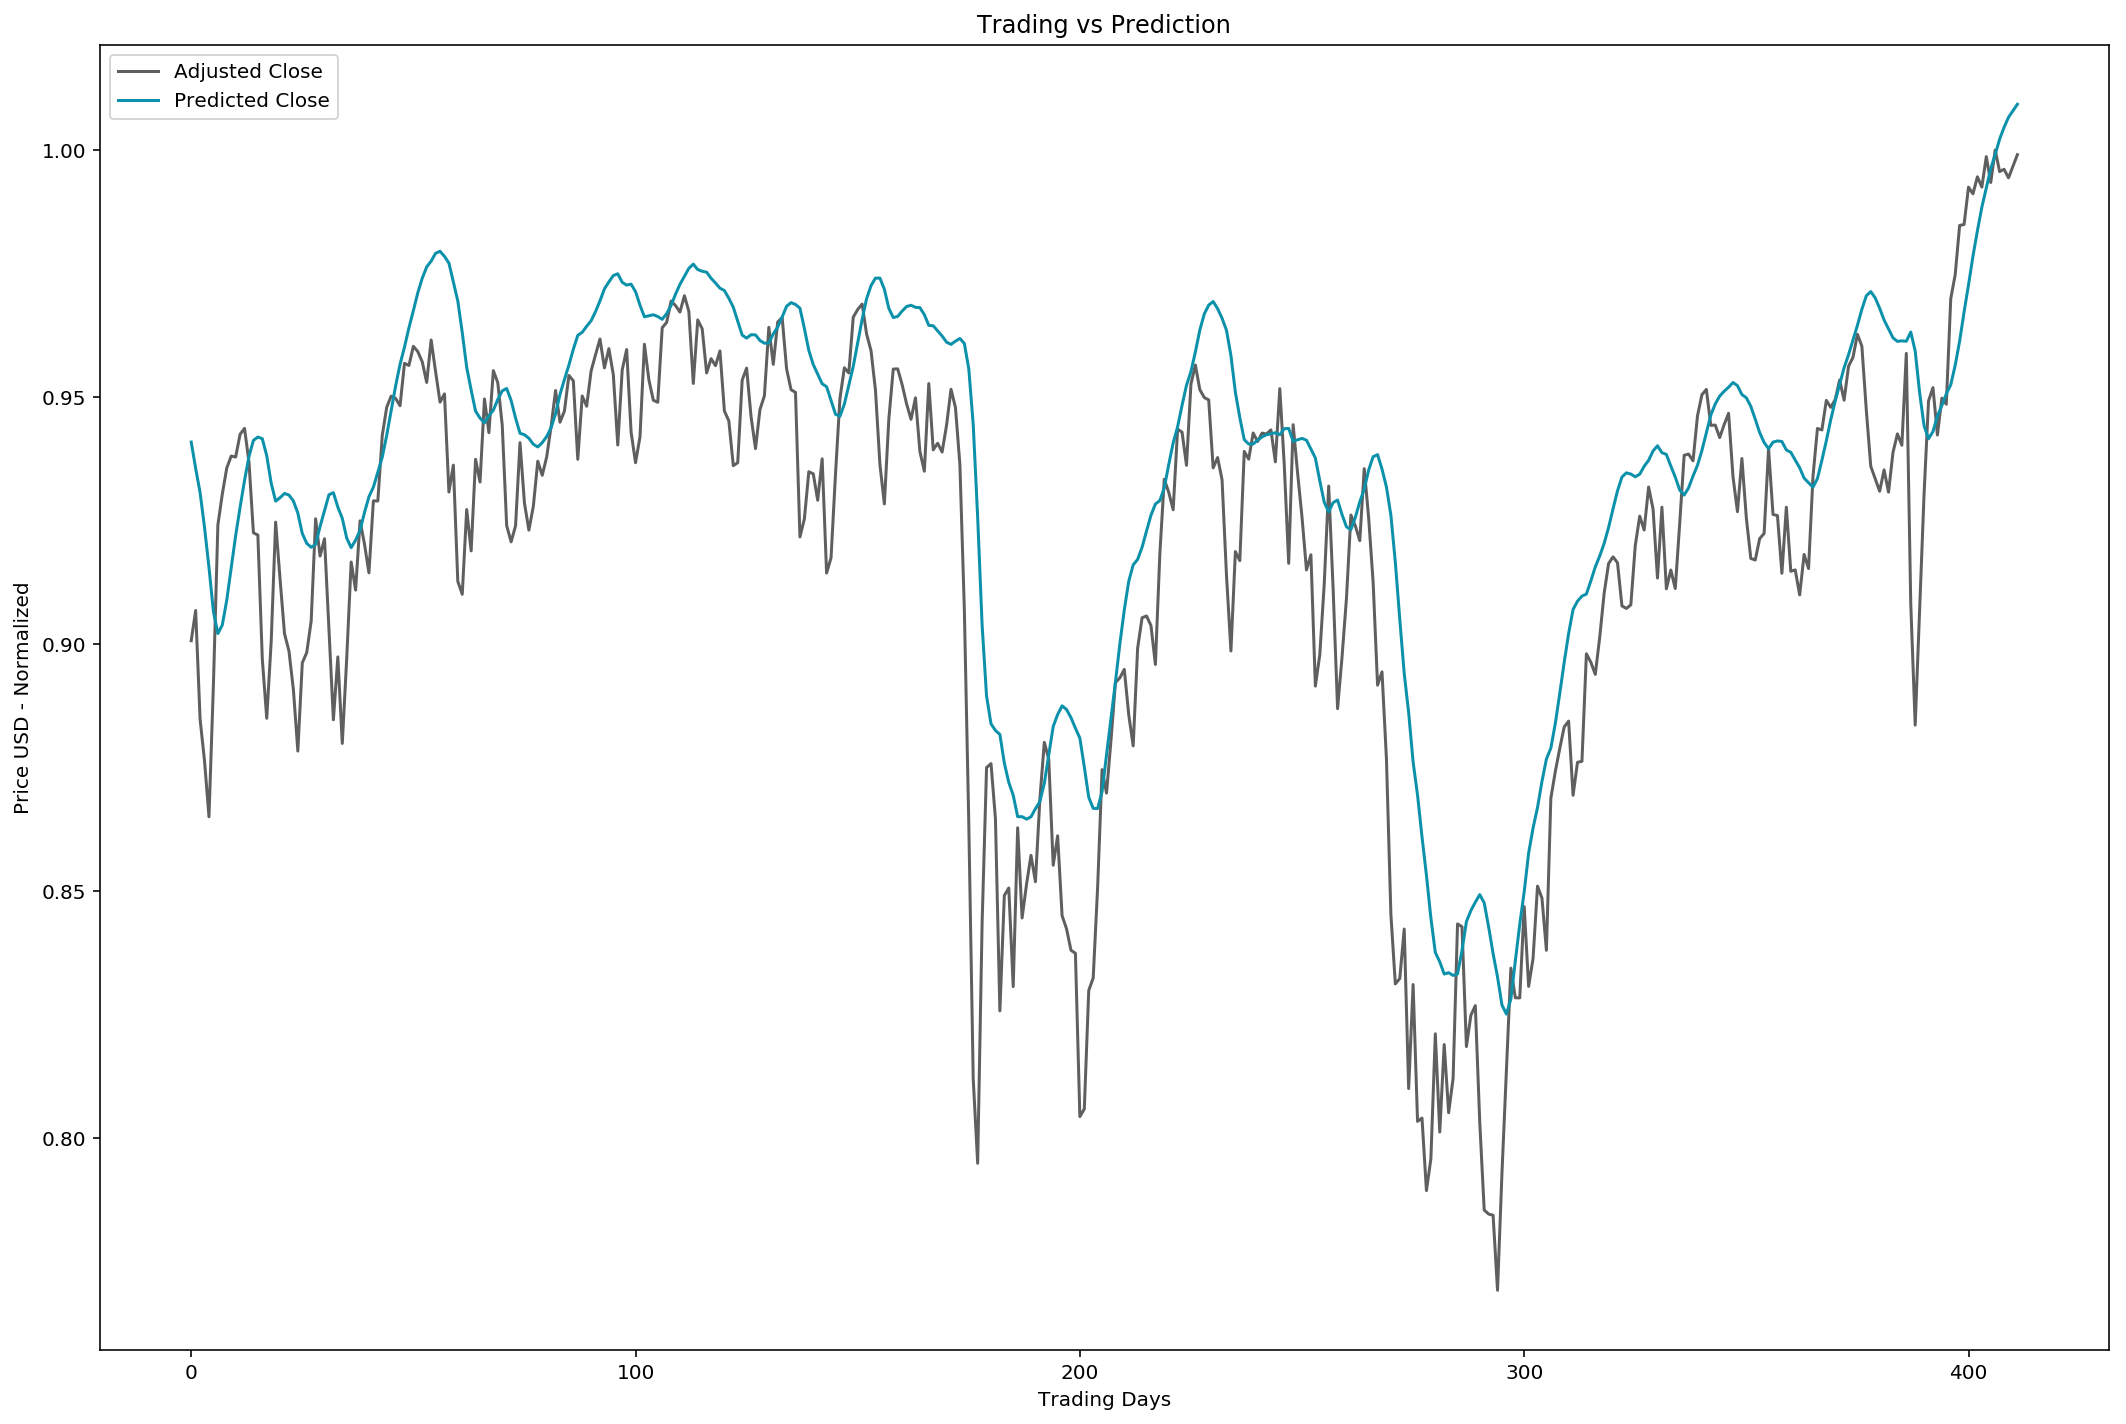

In [32]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, X_test, 1, 1)
#lstm.plot_results_multiple(predictions, y_test, batch_size)


# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(y_test,'#5F5F5F', label='Adjusted Close')
plt.plot(predictions, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [33]:
preds = np.array(predictions).flatten()
#print(preds)
# The mean squared error
testScore = mean_squared_error(y_test, preds)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.0008 MSE (0.0275 RMSE)


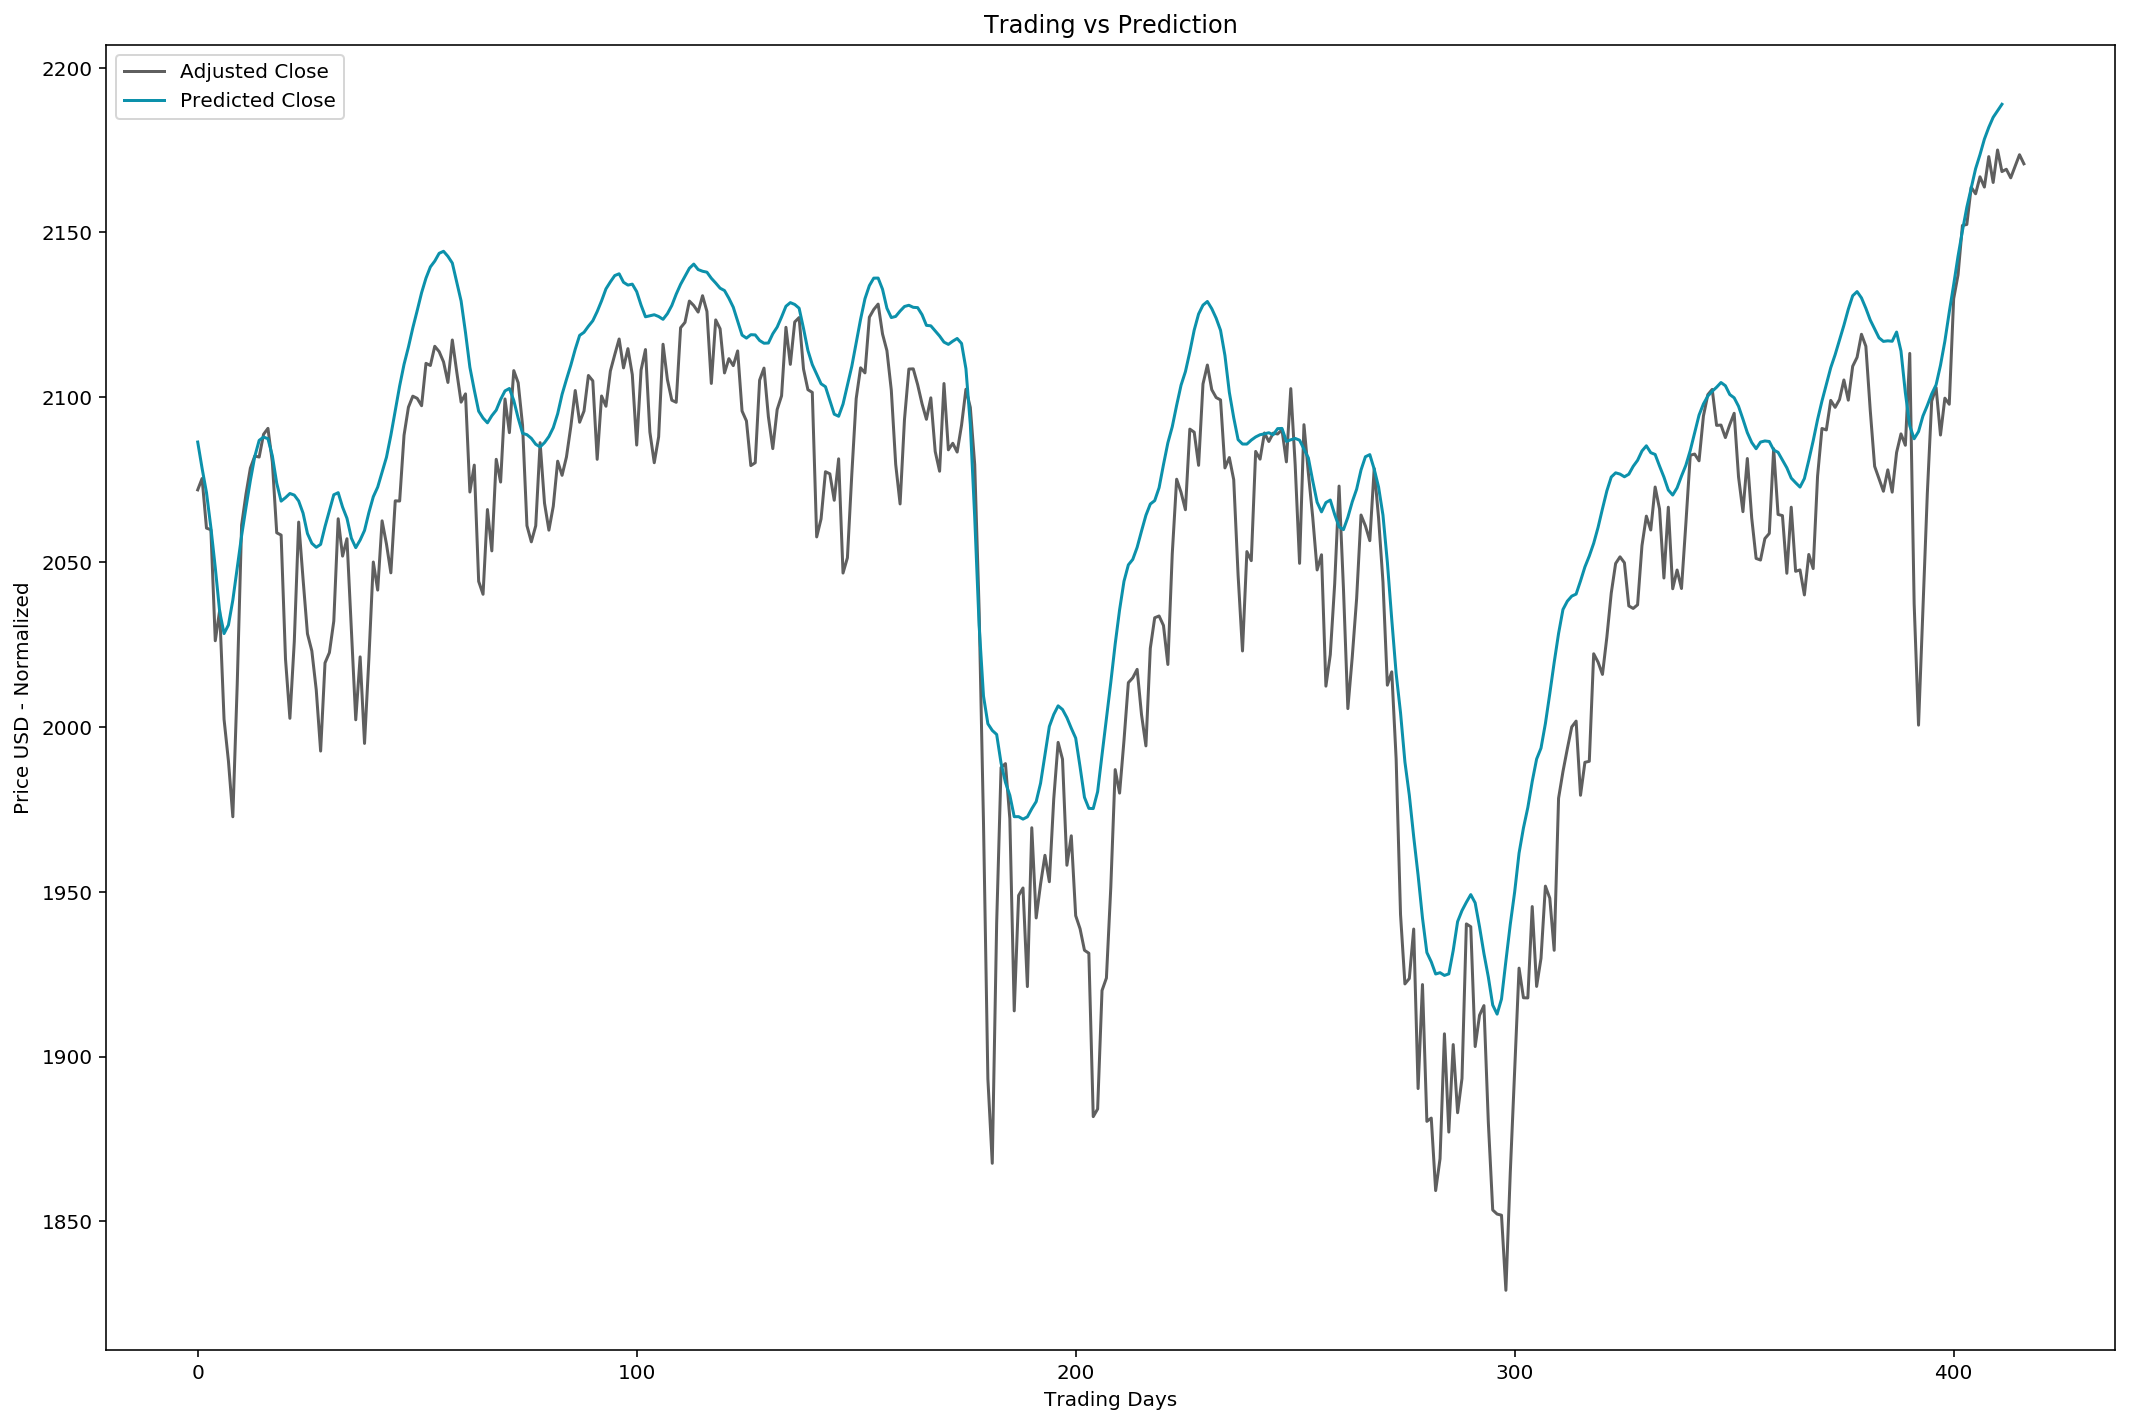

In [34]:
close_plot = adj_close[round(tt_split * len(adj_close)):]

pred_seq = np.array(predictions)
#pprint(pred_seq)
preds_seq_plot, r = scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)
#pprint(preds_seq_plot)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [35]:
testScore_seq = mean_squared_error(y_test, pred_seq)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore_seq, math.sqrt(testScore_seq)))

Test Score: 0.0008 MSE (0.0275 RMSE)


No Dropout: Test Score: 0.0003 MSE (0.0173 RMSE)

Dropout 20%: Test Score: 0.0002 MSE (0.0124 RMSE)